# Portfolio Allocation Strategies: Equal-Weight vs Inverse-Volatility vs S&P500



In this project we focus on **portfolio allocation rules** — simple heuristics that decide how to split our money across assets.

We test two **non-optimization strategies** and compare them against the **S&P 500** benchmark:

- **Equal-Weight (EW)**  
  Every stock gets the same share.  
  $w_i = \frac{1}{N}$

- **Inverse-Volatility (IVOL)**  
  Safer (less volatile) stocks get higher weight.  
  $w_i \propto \frac{1}{\sigma_i}$

These rules are **not derived from an optimization objective** (like Markowitz or Max-Sharpe).  
They are **rules/heuristics**: just apply the formula and get weights.

- **EW** ignores risk but ensures diversification.  
- **IVOL** adapts to volatility, penalizing “risky” assets.  
- **S&P 500** acts as a benchmark: if our rules cannot beat the index, they are not useful.


#### What we test ? 
- Build portfolios using **EW** and **IVOL** over a basket of 13 assets (US tech, finance, energy, consumer staples, gold, bonds, plus Viohalco from Athens).  
- Compare against **S&P 500 (benchmark)**.  
- Evaluate results with **Equity curves** (growth of $1 invested) and **KPIs** (CAGR, Volatility, Sharpe, Max Drawdown).


⚠️ *This is educational only — not investment advice.*



In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm


ASSETS = [
    "AAPL", "MSFT", "NVDA", "GOOGL", "AMZN",   # US Tech
    "JPM", "BAC",                              # Finance
    "XOM", "CVX",                              # Energy
    "PG", "KO",                                # Consumer staples
    "GLD", "TLT",                              # Diversifiers (Gold, US Bonds)
    "VIO.AT"                                   # Viohalco ( Industrial )
]
BENCH_TICKER = "^GSPC"  # S&P 500
START = "2016-01-01"
LOOKBACK_MONTHS = 6   # for IVOL weights


The stocks we are interested in are:
- Apple, Microsoft, NVIDIA, Google, Amazon, JPMorgan Chase, Bank of America, Viohalco
- ExxonMobil, Chevron, Procter & Gamble, Coca-Cola, SPDR Gold ETF (Gold exposure)
- iShares 20+ Year Treasury Bond ETF (US Bonds), 

In [2]:
# function that always return dataframe
def get_close_df(tickers, start):
    """Download Adjusted Close and always return DataFrame with columns=tickers."""
    data = yf.download(tickers, start=start, auto_adjust=True, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        df = data["Close"].copy()                     # already columns per ticker
    else:
        df = data[["Close"]].copy()                   # single-ticker case
        if isinstance(tickers, list) and len(tickers) == 1:
            df.columns = [tickers[0]]
        elif isinstance(tickers, str):
            df.columns = [tickers]
    return df.dropna(how="all")

# Download & preprocessing
px_assets = get_close_df(ASSETS, START)
px_bench  = get_close_df(BENCH_TICKER, START) # single ticker -> DataFrame with "^GSPC"

# Monthly closes and returns
pxm_assets = px_assets.resample("M").last().dropna(how="all")
retm_assets = pxm_assets.pct_change().dropna(how="all")

pxm_bench  = px_bench.resample("M").last().dropna(how="all")
bench_eq   = (1 + pxm_bench[BENCH_TICKER].pct_change().dropna()).cumprod()
bench_eq   = bench_eq / bench_eq.iloc[0]    # index to 1


C:\Users\User\AppData\Local\Temp\ipykernel_20128\2192937758.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pxm_assets = px_assets.resample("M").last().dropna(how="all")
C:\Users\User\AppData\Local\Temp\ipykernel_20128\2192937758.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pxm_bench  = px_bench.resample("M").last().dropna(how="all")


##  Helper metrics (CAGR, Vol, Sharpe, MaxDD)

### Performance Metrics (KPIs)

We measure performance with four metrics:

1. **CAGR (Compound Annual Growth Rate)**  
$$
\text{CAGR} = \left(\frac{V_{T}}{V_{0}}\right)^{1/n} - 1
$$  
where $V_T$ is final value, $V_0$ initial, and $n$ years.


2. **Volatility (annualized)**  
$$
\sigma_{ann} = \text{stdev}(r_m) \times \sqrt{12}
$$  
where $r_m$ = monthly returns.


3. **Sharpe Ratio (approx, rf=0)**  
$$
S = \frac{\mu_{ann}}{\sigma_{ann}}, \quad
\mu_{ann} = \text{mean}(r_m)\times 12
$$


4. **Max Drawdown (MDD)**  
$$
\text{MDD} = \min_t \left( \frac{V_t}{\max_{s \leq t} V_s} - 1 \right)
$$  
largest drop from peak to trough.

#### equity_from_returns

- Input: monthly returns, e.g. [0.02, -0.01, 0.03, …].
- Output: the **equity curve** (value of $1 invested growing over time).

**Meaning in practice:**  
- If you invest $1 and the first month you gain +2% → $1.02.  
- Next month −1% → $1.02 × 0.99 = $1.0098, etc.  
- This is **compounding of returns**.

**Mathematical formula (inline, VS Code friendly):**  
$$
V_t = \prod_{k=1}^{t} (1 + r_k)
$$


In [3]:
# KPI helpers
def equity_from_returns(r: pd.Series) -> pd.Series:
    eq = (1 + r).cumprod()
    return eq / eq.iloc[0]

def cagr_from_equity(eq: pd.Series) -> float:
    months = len(eq)
    if months < 2: return np.nan
    total = eq.iloc[-1] / eq.iloc[0]
    years = months / 12
    return total**(1/years) - 1

def vol_annualized(r: pd.Series) -> float:
    return r.std() * np.sqrt(12)

def sharpe_approx(r: pd.Series) -> float:
    mu_ann = r.mean() * 12
    vol_ann = vol_annualized(r)
    return mu_ann / vol_ann if vol_ann > 0 else np.nan

def max_drawdown(eq: pd.Series) -> float:
    roll_max = eq.cummax()
    dd = eq/roll_max - 1
    return dd.min()  # negative number

What are these strategies?
In finance, there are many ways to decide **how to split your money across different assets**.  
Here we test two simple **non-optimization** rules and compare them to the S&P 500.


### a) Equal-Weight (EW)
- **Idea:** Put the same money in each stock, regardless of size or risk.  
  Example: 10 stocks → 10% each.
- **Why:** Simple diversification; you don’t overbet on one name.
- **Downside:** Ignores risk.
- **Formula:** $w_i = \frac{1}{N}$, where $N$ = number of assets.


### b) Inverse-Volatility (IVOL)
- **Idea:** Give more weight to “calmer” stocks, less to “wild” ones.  
  Volatility ≈ how much returns fluctuate.
- **Why:** Smoother ride; penalizes risky names.
- **How:** Use past $L$ months (here $L=6$) to measure volatility.
- **Formula:** $w_i = \dfrac{1/\sigma_i}{\sum_j 1/\sigma_j}$, where $\sigma_i$ = std. dev. of returns for asset $i$.


### c) Benchmark — S&P 500 (^GSPC)
- **Role:** Yardstick. If a rule can’t beat the index (in return or risk-adjusted terms), it’s not useful.

How does this make money?
Each month the portfolio return is:
$R_{p,t} = \sum_{i=1}^{N} w_{i,t}\, r_{i,t}$

- $w_{i,t}$ = weight of asset $i$ at month $t$  
- $r_{i,t}$ = return of asset $i$ at month $t$

Over time, monthly returns **compound** and show how \$1 grows.


Pipeline we implement:
1. Define weights (EW or IVOL).
2. Multiply by monthly returns to get $R_{p,t}$.
3. Build the equity curve from compounding.
4. Compare to S&P 500.


## Strategies (EW & IVOL monthly rebalance)

In [4]:
def equal_weight_weights(cols):
    return pd.Series(1/len(cols), index=cols)

def ivol_weights(ret_window: pd.DataFrame):
    vol = ret_window.std()
    inv = 1 / vol.replace(0, np.nan)
    w = inv / inv.sum()
    return w.fillna(0.0)

def run_strategy(retm_assets: pd.DataFrame, method="EW", lookback=6):
    cols = retm_assets.columns
    eq = [1.0]
    all_returns = []

    for i in range(len(retm_assets)):
        # choose weights for month i
        if i < lookback:
            w = equal_weight_weights(cols)  # warm-up
        else:
            if method == "EW":
                w = equal_weight_weights(cols)
            elif method == "IVOL":
                window = retm_assets.iloc[i-lookback:i]
                w = ivol_weights(window)
            else:
                w = equal_weight_weights(cols)

        # portfolio return this month
        r_m = retm_assets.iloc[i].fillna(0.0)
        pr = float((r_m * w).sum())
        all_returns.append(pr)
        eq.append(eq[-1] * (1 + pr))

    eq_series = pd.Series(eq[1:], index=retm_assets.index)
    ret_series = pd.Series(all_returns, index=retm_assets.index)
    return eq_series, ret_series

### How the strategy algorithm works (EW / IVOL)

This function implements a **backtesting loop with monthly rebalancing**.  
It does not solve an optimization problem — instead it applies **heuristics (rules)** to generate portfolio weights.

1. **Compute weights $w_{i,t}$ each month:**
   - **Equal-Weight (EW):** all assets get the same weight.  
     $w_i = \frac{1}{N}$
   - **Inverse-Volatility (IVOL):** assets with lower volatility get higher weights.  
     $w_i = \dfrac{1/\sigma_i}{\sum_j 1/\sigma_j}$  
     where $\sigma_i$ = standard deviation of past $L$ months returns (lookback window).

2. **Calculate portfolio return for the month:**  
   $R_{p,t} = \sum_{i=1}^N w_{i,t}\, r_{i,t}$  
   where $r_{i,t}$ is the return of asset $i$ at month $t$.

3. **Update the equity curve:**  
   $V_t = V_{t-1} \times (1 + R_{p,t})$

Outputs
- **Equity curve:** how $1 invested grows over time under the chosen rule.  
- **Monthly returns:** sequence of $R_{p,t}$, used later for KPIs (CAGR, Volatility, Sharpe, Max Drawdown).

Considering all the above, the algorithm is a **simulation engine** that rebalances each month using either EW or IVOL rules, and shows how the portfolio would have evolved historically.

##  EW & IVOL and pick a benchmark

Running the strategies and setting the benchmark.

Here we simply execute the **two allocation rules** over the historical data. (above strategy function)

In [5]:
eq_ew,   r_ew   = run_strategy(retm_assets, method="EW",   lookback=LOOKBACK_MONTHS)
eq_ivol, r_ivol = run_strategy(retm_assets, method="IVOL", lookback=LOOKBACK_MONTHS)

# Align benchmark equity to strategies period
bench_eq = bench_eq.loc[eq_ew.index.min():eq_ew.index.max()]

##  Plot equity curves

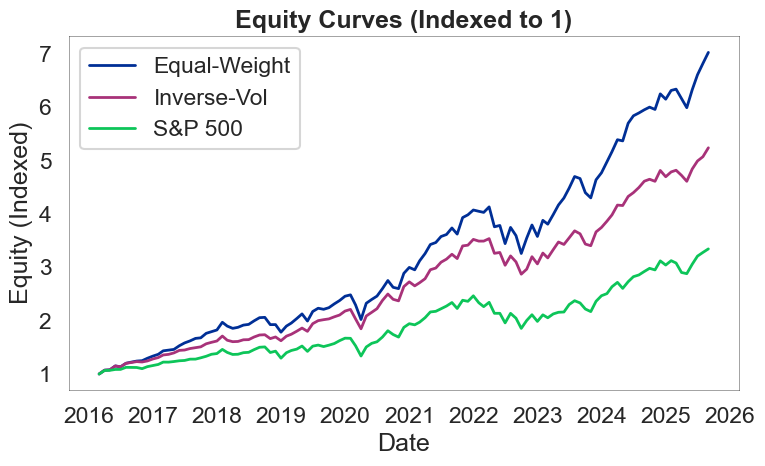

In [6]:

df_plot = pd.DataFrame({
    "Equal-Weight": eq_ew / eq_ew.iloc[0],
    "Inverse-Vol":  eq_ivol / eq_ivol.iloc[0],
    "S&P 500":      bench_eq / bench_eq.iloc[0],
}, index=eq_ew.index)

df_plot = df_plot.reset_index().melt(
    id_vars="Date", var_name="Strategy", value_name="Equity")

sns.set_theme(style="white", context="talk")
plt.figure(figsize=(8,5))

sns.lineplot(data=df_plot, x="Date", y="Equity",
            hue="Strategy", linewidth=2, palette=["#002F96", "#A83279", "#0DC559"])

plt.title("Equity Curves (Indexed to 1)", weight="bold")
plt.xlabel("Date")
plt.ylabel("Equity (Indexed)")
plt.legend(title="", loc="upper left", frameon=True)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0.6)  
    spine.set_alpha(0.5)       

plt.tight_layout()
plt.show()

The chart shows how **$1 invested in 2016** would have grown under three different approaches:

- **Equal-Weight (blue)**  
  Grows the fastest, reaching over **7× the initial investment**.  
  - Putting the same money in each stock heavily benefited from big winners (Apple, Microsoft, NVIDIA).  
  - Downside: larger swings — higher volatility along the way.

- **Inverse-Volatility (purple)**  
  Ends up at ~**5× the initial investment**.  
  - A smoother ride: by giving more weight to calmer assets, the drawdowns are smaller.  
  - Sacrifices some upside compared to EW, but offers lower risk exposure.

- **S&P 500 benchmark (green)**  
  Ends up around **3.3× the initial investment**.  
  - Both EW and IVOL clearly outperform the benchmark in this sample.  
  - Shows that even simple heuristics can add value compared to just buying the index.


In money terms this mean that starting with $10,000 in 2016:
  - **Equal-Weight** → grows to ~$70,000.  
  - **Inverse-Volatility** → grows to ~$50,000.  
  - **S&P 500** → grows to ~$33,000.  

The Key insight is that the Equal-Weight strategy achieved the strongest overall growth, though with higher volatility. In contrast, the Inverse-Volatility approach delivered a smoother and more balanced risk-return profile, giving up some upside in exchange for lower risk. Over this historical period, both simple allocation rules managed to outperform the S&P 500 benchmark.

⚠️ Past performance ≠ future performance. This is a **backtest on one dataset** — not a guarantee for future results.


### KPIs table

In [7]:
rows = []
for name, eq, r in [
    ("Equal-Weight", eq_ew, r_ew),
    ("Inverse-Vol",  eq_ivol, r_ivol),
]:
    rows.append([name, cagr_from_equity(eq), vol_annualized(r), sharpe_approx(r), max_drawdown(eq)])

# Benchmark KPIs
r_bench = bench_eq.pct_change().dropna()
rows.append([BENCH_TICKER, cagr_from_equity(bench_eq), vol_annualized(r_bench), sharpe_approx(r_bench), max_drawdown(bench_eq)])

kpi_df = pd.DataFrame(rows, columns=["Strategy", "CAGR", "Volatility", "Sharpe", "Max Drawdown"]).set_index("Strategy")
kpi_df.style.format({"CAGR": "{:.2%}", "Volatility": "{:.2%}", "Sharpe": "{:.2f}", "Max Drawdown": "{:.2%}"})


,CAGR,Volatility,Sharpe,Max Drawdown
Strategy,,,,
Equal-Weight,22.57%,15.35%,1.39,-21.13%
Inverse-Vol,18.87%,13.14%,1.37,-18.83%
^GSPC,13.43%,15.32%,0.91,-24.77%


The table summarizes how each strategy performed (2016–2025):

- **Equal-Weight (EW)**  
  - **CAGR:** 22.6% → highest growth rate.  
  - **Volatility:** 15.4% → relatively high risk.  
  - **Sharpe:** 1.39 → very solid risk-adjusted performance.  
  - **Max Drawdown:** −21% → suffered sizable dips, but not the worst.

- **Inverse-Volatility (IVOL)**  
  - **CAGR:** 18.9% → lower growth than EW, but still strong.  
  - **Volatility:** 13.1% → less risk, smoother ride.  
  - **Sharpe:** 1.37 → nearly as good as EW in risk-adjusted terms.  
  - **Max Drawdown:** −18.8% → smallest drop among the three, the most defensive profile.

- **S&P 500 (benchmark)**  
  - **CAGR:** 13.4% → much lower growth.  
  - **Volatility:** 15.3% → risk as high as EW, but with less reward.  
  - **Sharpe:** 0.91 → worst risk-adjusted return.  
  - **Max Drawdown:** −24.8% → deepest losses in bad times.

Both **EW** and **IVOL** clearly outperform the S&P 500 over this period.  
- **EW** delivers the most growth, but with higher swings.  
- **IVOL** is safer, sacrificing some upside but protecting better in downturns.  
- The benchmark lags behind on all fronts.
